In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import os
from transformers import ViTConfig, ViTForImageClassification

In [2]:
# Load your trained model
model_save_path = "vit_model-1.pth"  # Path to your saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model configuration
config = ViTConfig(
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=16,
    image_size=224,
    patch_size=8,
    num_labels=2,
    dropout_rate=0.05
)

# Initialize the model
model = ViTForImageClassification(config)

# Load the model state dict with weights_only=True to avoid the warning
model.load_state_dict(torch.load(model_save_path, weights_only=True, map_location=device))  # Ensure it loads to the correct device
model.to(device)  # Transfer model to the specified device (cuda or cpu)
model.eval()  # Set the model to evaluation mode

print("Model loaded and transferred to device:", device)


Model loaded and transferred to device: cuda


In [3]:
class GradCAM:
    def __init__(self, model, layer_choice='10'):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None

        # Register hooks on the chosen encoder layer
        if layer_choice == '10':
            # Hook for the 10th layer
            self.model.vit.encoder.layer[10].output.register_forward_hook(self.save_activation)
            self.model.vit.encoder.layer[10].output.register_full_backward_hook(self.save_gradient)  # Use full backward hook
            print("Using the 10th layer for Grad-CAM.")
        elif layer_choice == '6':
            # Hook for the 6th layer
            self.model.vit.encoder.layer[6].output.register_forward_hook(self.save_activation)
            self.model.vit.encoder.layer[6].output.register_full_backward_hook(self.save_gradient)  # Use full backward hook
            print("Using the 6th layer for Grad-CAM.")
        else:
            raise ValueError("Invalid layer_choice. Choose '6' or '10'.")


    def save_activation(self, module, input, output):
        # Exclude the CLS token
        self.activations = output[:, 1:, :]

    def save_gradient(self, module, grad_input, grad_output):
        # Exclude the CLS token
        self.gradients = grad_output[0][:, 1:, :]

    def generate_heatmap(self, index):
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations are not available. Ensure the backward pass is computed correctly.")
    
        # Calculate the gradient-weighted class activation
        weights = torch.mean(self.gradients, dim=1, keepdim=True)
        cam = torch.sum(weights * self.activations, dim=2).squeeze()
    
        # Reshape CAM to match the spatial structure of the patch grid (28x28 for 784 patches)
        if cam.shape[0] != 784:
            raise ValueError(f"Unexpected cam shape: {cam.shape}. Expected 784 elements.")
        
        cam = cam.reshape(28, 28)
        cam = F.relu(cam)
        
        # Apply softmax normalization for weighted aggregation
        weights = F.softmax(cam.view(-1), dim=0)  # Normalizing the CAM values
        weighted_cam = (weights.view(cam.shape) * cam)  # Weighted sum of patches

        # Normalize and return the final heatmap
        cam = weighted_cam - weighted_cam.min()
        cam = cam / (cam.max() + 1e-8)  # Normalize to [0, 1] with epsilon
        return cam


Using the 6th layer for Grad-CAM.


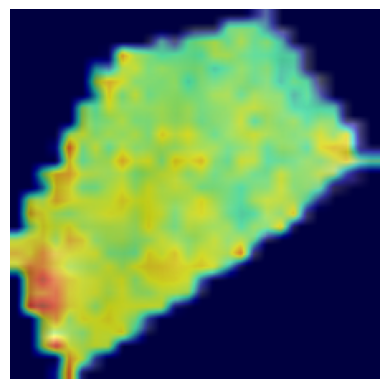

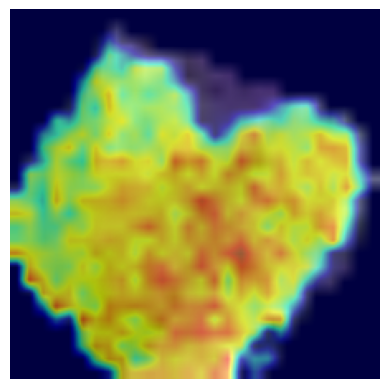

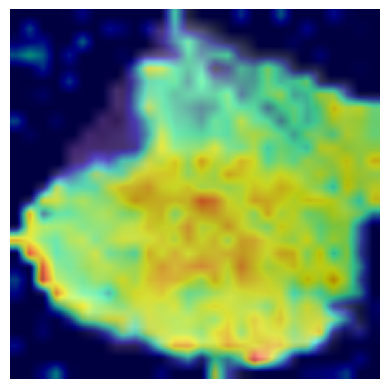

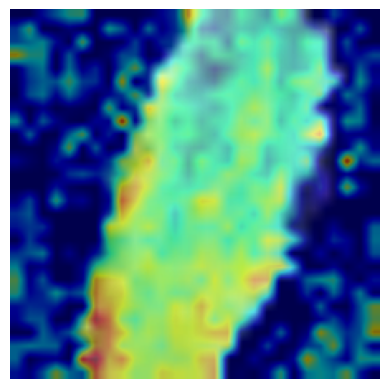

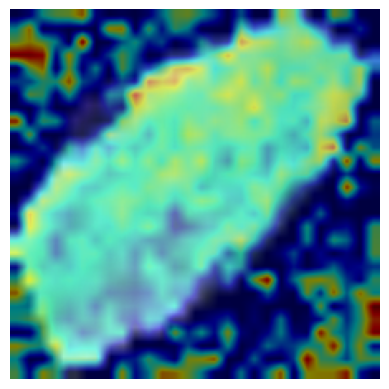

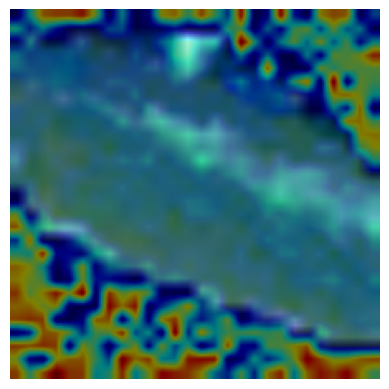

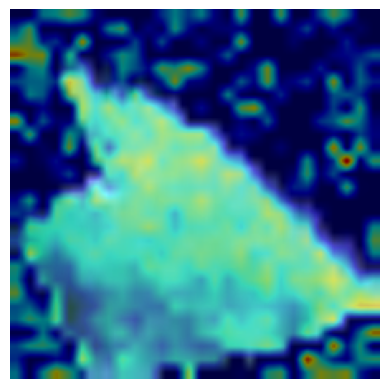

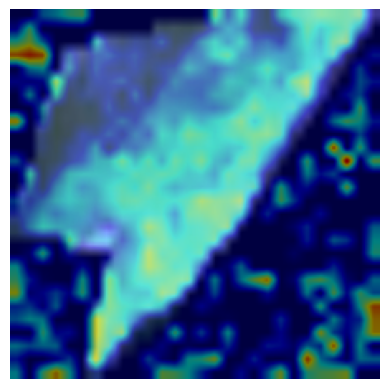

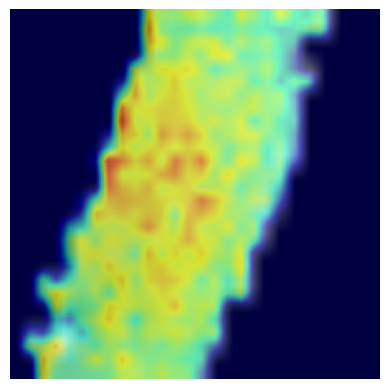

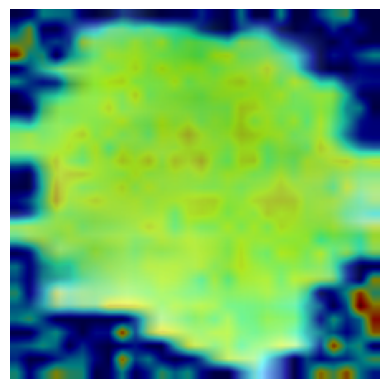

Processed 10 images


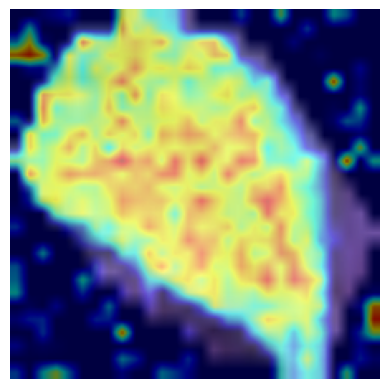

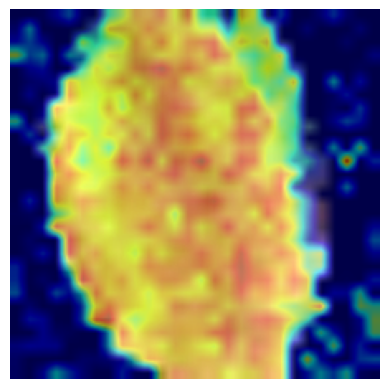

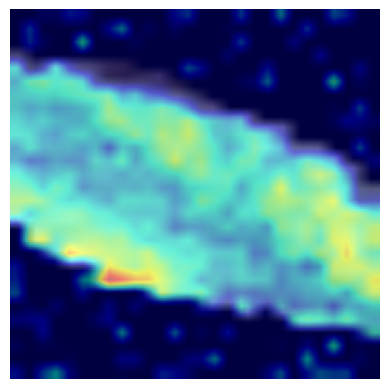

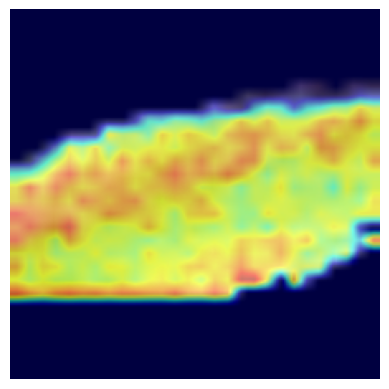

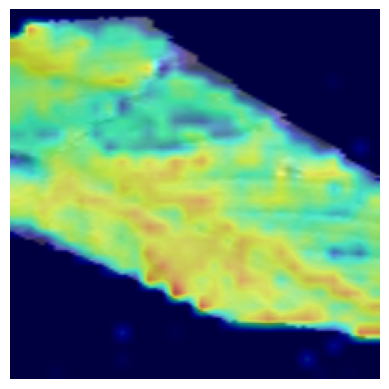

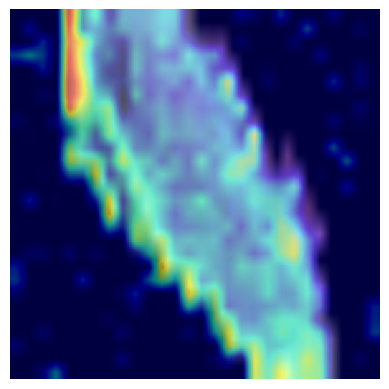

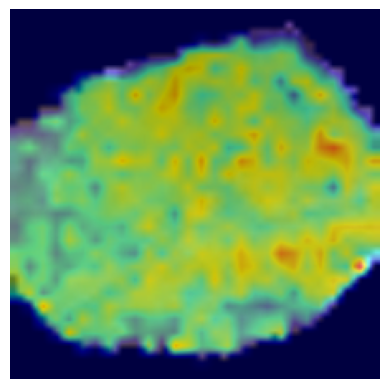

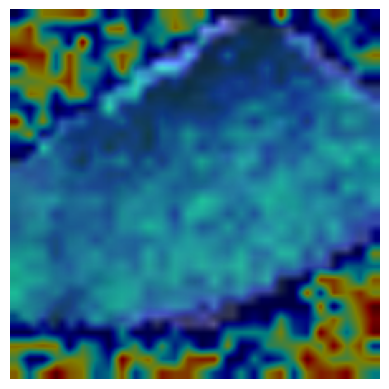

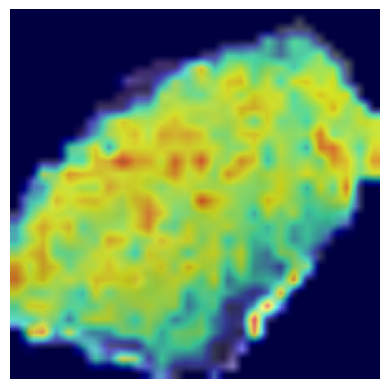

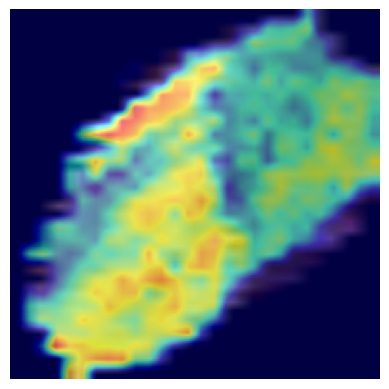

Processed 20 images


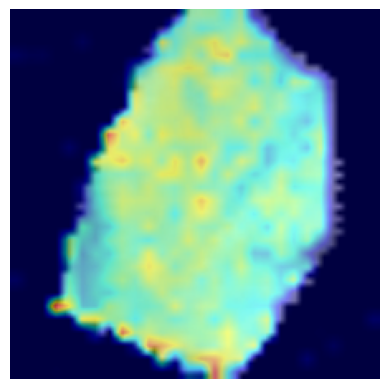

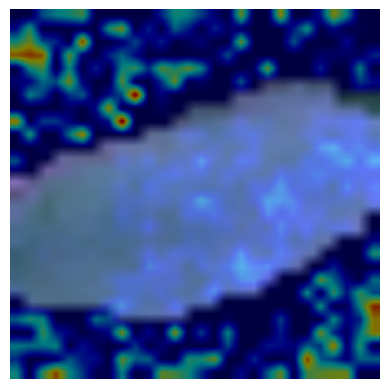

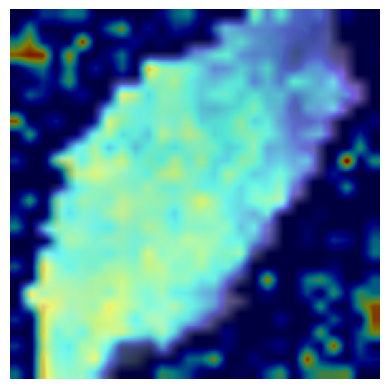

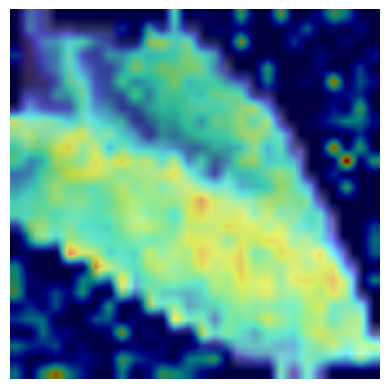

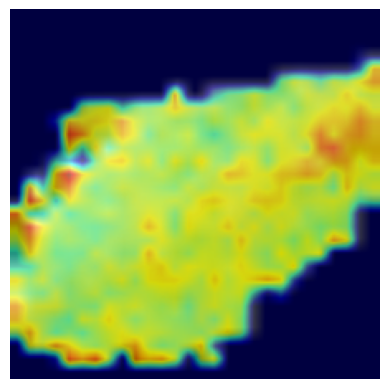

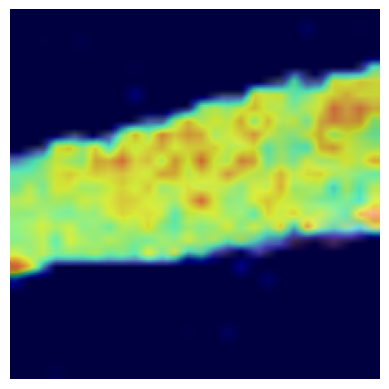

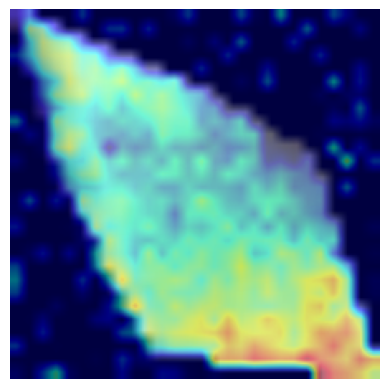

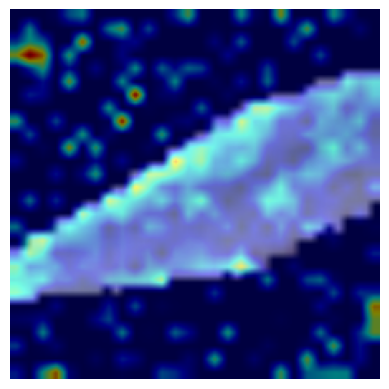

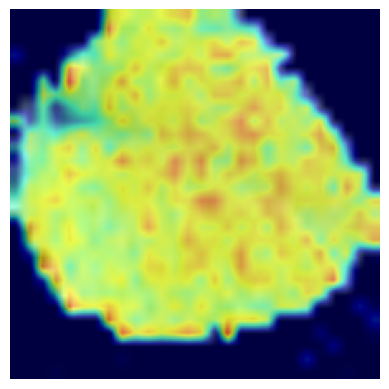

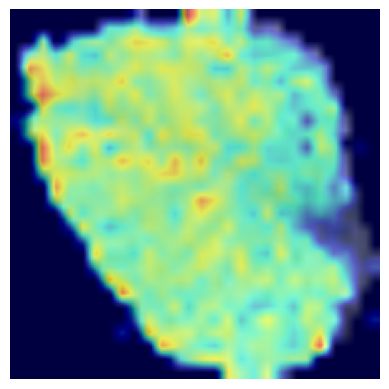

Processed 30 images


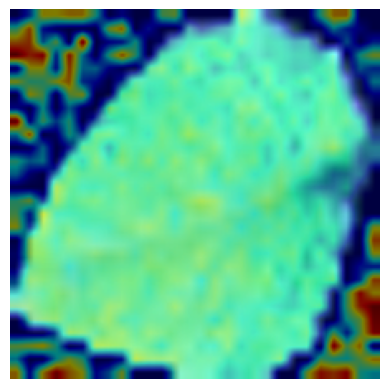

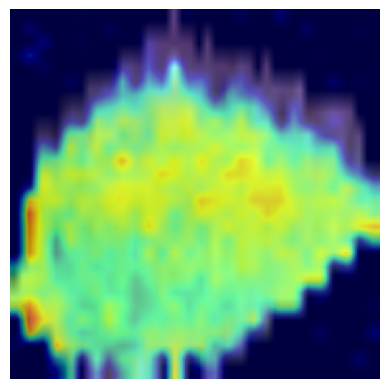

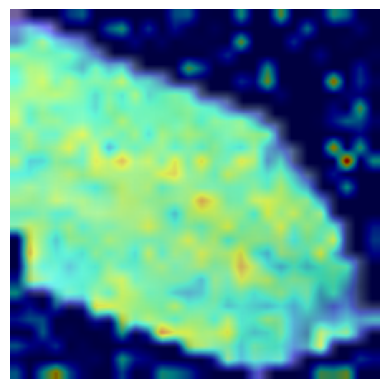

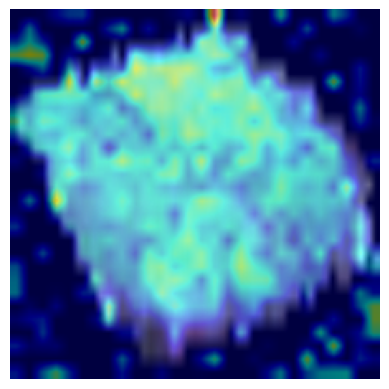

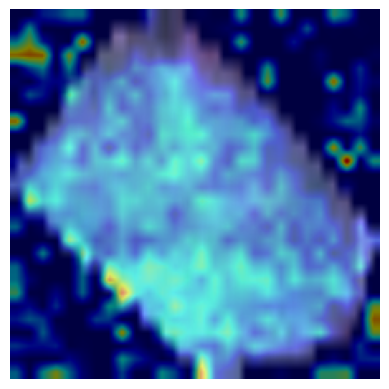

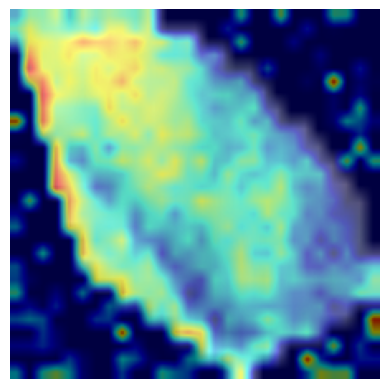

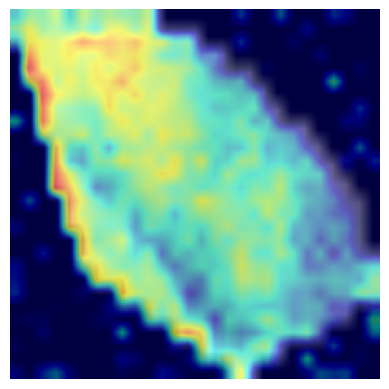

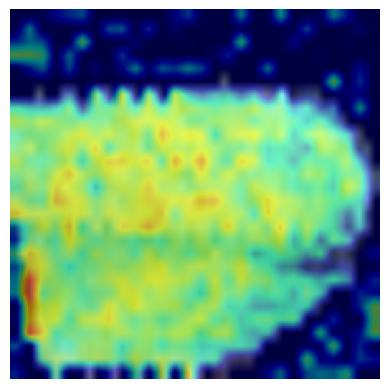

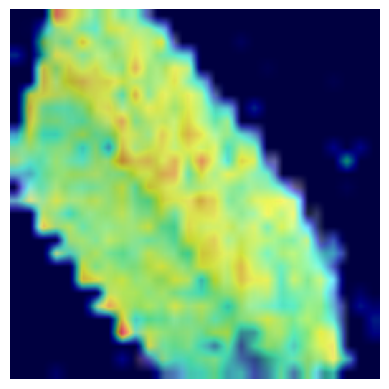

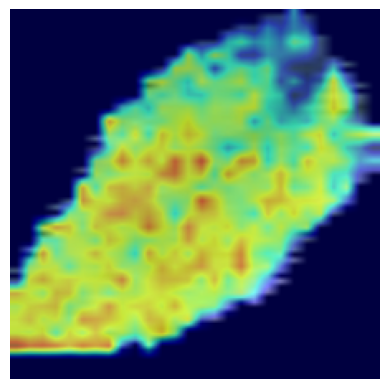

Processed 40 images


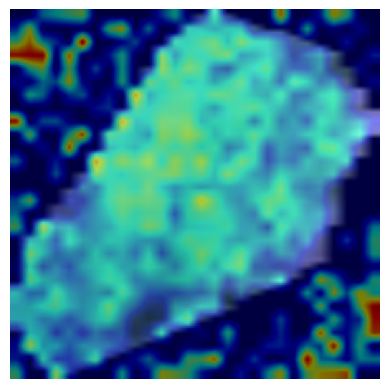

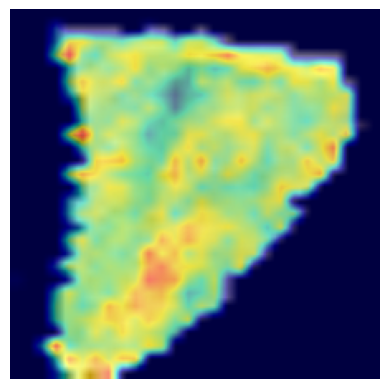

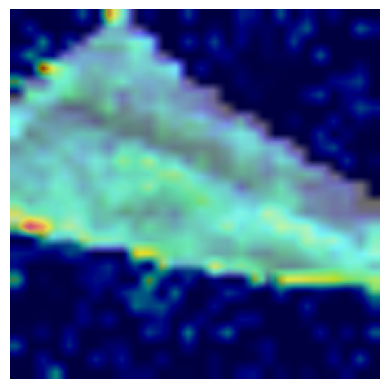

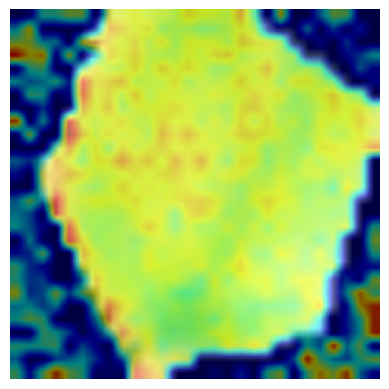

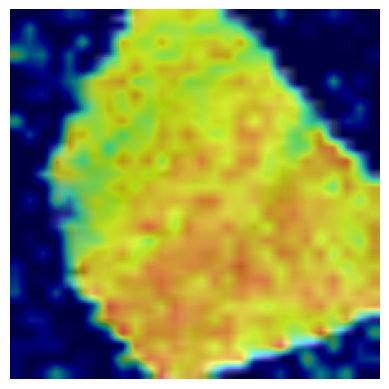

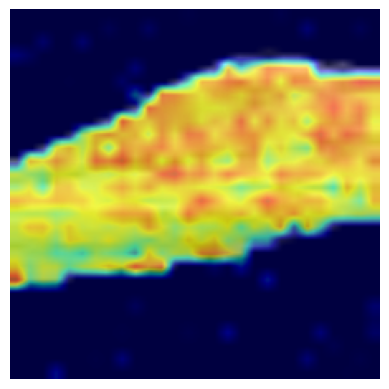

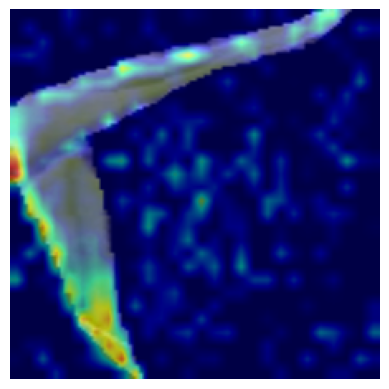

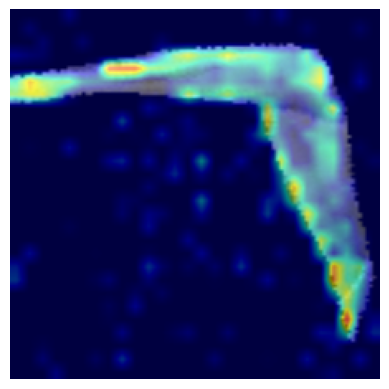

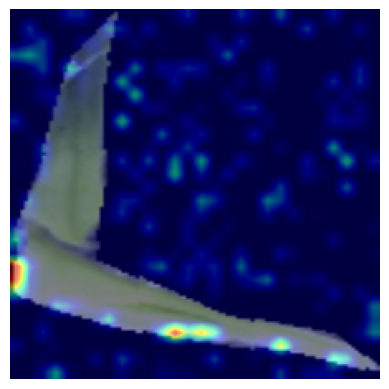

In [8]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Visualize the Grad-CAM output with a transparent overlay
def visualize_gradcam(original_image, heatmap, alpha=0.5):
    heatmap = heatmap.cpu().detach().numpy()
    heatmap = np.uint8(255 * heatmap)  # Scale to [0, 255]
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Apply colormap to heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Normalize original image per channel
    original_image = original_image - np.min(original_image, axis=(0, 1), keepdims=True)
    original_image = original_image / (np.max(original_image, axis=(0, 1), keepdims=True) + 1e-8)
    original_image = np.uint8(255 * original_image)

    # Convert original image to BGR format for overlay
    original_image_bgr = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)

    # Superimpose the heatmap onto the original image with transparency
    superimposed_img = cv2.addWeighted(original_image_bgr, 1 - alpha, heatmap, alpha, 0)

    # Display the image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Initialize Grad-CAM with the loaded model
grad_cam = GradCAM(model, layer_choice='6')  # Change to '10' to use the 10th layer

# Define the root directory containing images
root_dir = "split-dataset-2/test/turmeric"

# Find all image paths ending with "png"
image_paths = [os.path.join(root_dir, filename) for filename in os.listdir(root_dir) if filename.endswith("png")]

# Process all images in the folder
for i, image_path in enumerate(image_paths[1:50]):
    # Load and prepare the test image
    test_image = load_image(image_path).to(device)

    # Forward pass to get predictions
    outputs = model(test_image)  # Get the whole output
    logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]  # Access logits
    predicted_class = torch.argmax(logits, dim=1)

    # Backward pass to get gradients
    loss = logits[0][predicted_class]
    loss.backward()

    # Generate heatmap
    heatmap = grad_cam.generate_heatmap(predicted_class)

    # Visualize the original image and the heatmap
    visualize_gradcam(test_image.cpu().squeeze().numpy().transpose(1, 2, 0), heatmap)

    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1} images")